In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 2")
    device_num = 1
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 4

max_epochs = 1000

net_dims = 3
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 2

num_slices = 48
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-NRS"

Device number assumed to be 2


In [3]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Num images / labels = 62 62


In [4]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz
../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.interpolated-overlay.nii.gz


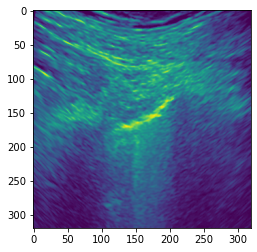

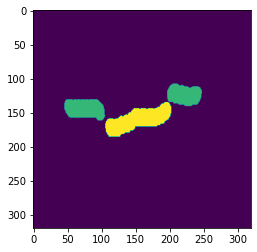

In [5]:
foldnum = 0
imgnum = 40
channelnum = 0

print(train_files[foldnum][imgnum]["image"])
print(train_files[foldnum][imgnum]["label"])

img = itk.imread(train_files[foldnum][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[foldnum][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[channelnum,:,:])
plt.subplots()
plt.imshow(arrlbl[channelnum,:,:])

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image', 'label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            center_slice=30,
            axis=3,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [7]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00, 12.18it/s]


torch.Size([2, 1, 320, 320, 48])
torch.Size([1, 320, 320, 48])
image shape: torch.Size([1, 320, 320, 48]), label shape: torch.Size([1, 320, 320, 48])


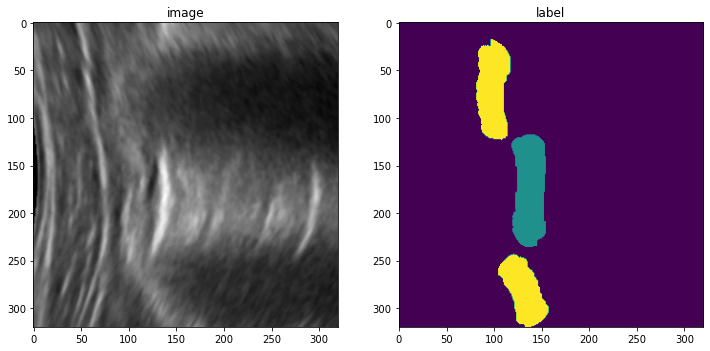

tensor(0.) tensor(2.)


In [8]:
imgnum = 0
batchnum = 0
channelnum = 0
slicenum = 24

check_data = first(val_loader[batchnum])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[channelnum, :, :, slicenum], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[channelnum, :, :, slicenum])
plt.show()
print(label.min(), label.max())

In [9]:
device = torch.device("cuda:"+str(device_num))


In [10]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2])/2
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
for i in range(0,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
0: epoch 1/1000
1/1, train_loss: 0.8604
2/1, train_loss: 0.8560
3/1, train_loss: 0.8540
4/1, train_loss: 0.8531
5/1, train_loss: 0.8560
6/1, train_loss: 0.8552
7/1, train_loss: 0.8546
0 epoch 1 average loss: 0.8556
----------
0: epoch 2/1000
1/1, train_loss: 0.8504
2/1, train_loss: 0.8492
3/1, train_loss: 0.8499
4/1, train_loss: 0.8507
5/1, train_loss: 0.8454
6/1, train_loss: 0.8450
7/1, train_loss: 0.8361
0 epoch 2 average loss: 0.8467
current epoch: 2 current mean dice: 0.0660
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 3/1000
1/1, train_loss: 0.8453
2/1, train_loss: 0.8453
3/1, train_loss: 0.8403
4/1, train_loss: 0.8396
5/1, train_loss: 0.8398
6/1, train_loss: 0.8331
7/1, train_loss: 0.8347
0 epoch 3 average loss: 0.8397
----------
0: epoch 4/1000
1/1, train_loss: 0.8378
2/1, train_loss: 0.8364
3/1, train_loss: 0.8349
4/1, train_loss: 0.8365
5/1, train_loss: 0.8349
6/1, train_loss: 0.8280
7/1, train_loss: 0.8308
0 epoch 4 average loss: 0.8342
current epoch: 4

7/1, train_loss: 0.6728
0 epoch 31 average loss: 0.6775
----------
0: epoch 32/1000
1/1, train_loss: 0.6736
2/1, train_loss: 0.6982
3/1, train_loss: 0.6752
4/1, train_loss: 0.6557
5/1, train_loss: 0.6768
6/1, train_loss: 0.6649
7/1, train_loss: 0.6506
0 epoch 32 average loss: 0.6707
current epoch: 32 current mean dice: 0.4245
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 33/1000
1/1, train_loss: 0.6635
2/1, train_loss: 0.6617
3/1, train_loss: 0.6740
4/1, train_loss: 0.6716
5/1, train_loss: 0.6665
6/1, train_loss: 0.6520
7/1, train_loss: 0.6638
0 epoch 33 average loss: 0.6647
----------
0: epoch 34/1000
1/1, train_loss: 0.6591
2/1, train_loss: 0.6583
3/1, train_loss: 0.6514
4/1, train_loss: 0.6606
5/1, train_loss: 0.6638
6/1, train_loss: 0.6604
7/1, train_loss: 0.6556
0 epoch 34 average loss: 0.6585
current epoch: 34 current mean dice: 0.2785
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 35/1000
1/1, train_loss: 0.6415
2/1, train_loss: 0.6366
3/1, train_loss: 0.664

4/1, train_loss: 0.5183
5/1, train_loss: 0.5323
6/1, train_loss: 0.5162
7/1, train_loss: 0.5265
0 epoch 62 average loss: 0.5195
current epoch: 62 current mean dice: 0.5448
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 63/1000
1/1, train_loss: 0.5082
2/1, train_loss: 0.5160
3/1, train_loss: 0.5126
4/1, train_loss: 0.5149
5/1, train_loss: 0.5193
6/1, train_loss: 0.5113
7/1, train_loss: 0.5022
0 epoch 63 average loss: 0.5121
----------
0: epoch 64/1000
1/1, train_loss: 0.5099
2/1, train_loss: 0.5044
3/1, train_loss: 0.5331
4/1, train_loss: 0.4959
5/1, train_loss: 0.5139
6/1, train_loss: 0.5116
7/1, train_loss: 0.4949
0 epoch 64 average loss: 0.5091
current epoch: 64 current mean dice: 0.5340
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 65/1000
1/1, train_loss: 0.5136
2/1, train_loss: 0.4996
3/1, train_loss: 0.5184
4/1, train_loss: 0.5068
5/1, train_loss: 0.5121
6/1, train_loss: 0.5152
7/1, train_loss: 0.5181
0 epoch 65 average loss: 0.5120
----------
0: epoch 66/100

1/1, train_loss: 0.4548
2/1, train_loss: 0.4560
3/1, train_loss: 0.4379
4/1, train_loss: 0.4559
5/1, train_loss: 0.4697
6/1, train_loss: 0.4444
7/1, train_loss: 0.4495
0 epoch 93 average loss: 0.4526
----------
0: epoch 94/1000
1/1, train_loss: 0.4606
2/1, train_loss: 0.4412
3/1, train_loss: 0.4795
4/1, train_loss: 0.4655
5/1, train_loss: 0.4498
6/1, train_loss: 0.4540
7/1, train_loss: 0.4472
0 epoch 94 average loss: 0.4568
current epoch: 94 current mean dice: 0.5287
best mean dice: -1.0000 at epoch: -1
----------
0: epoch 95/1000
1/1, train_loss: 0.4715
2/1, train_loss: 0.4526
3/1, train_loss: 0.4366
4/1, train_loss: 0.4448
5/1, train_loss: 0.4551
6/1, train_loss: 0.4471
7/1, train_loss: 0.4425
0 epoch 95 average loss: 0.4500
----------
0: epoch 96/1000
1/1, train_loss: 0.4442
2/1, train_loss: 0.4523
3/1, train_loss: 0.4417
4/1, train_loss: 0.4614
5/1, train_loss: 0.4430
6/1, train_loss: 0.4719
7/1, train_loss: 0.4337
0 epoch 96 average loss: 0.4497
current epoch: 96 current mean dice

1/1, train_loss: 0.3894
2/1, train_loss: 0.3966
3/1, train_loss: 0.4139
4/1, train_loss: 0.3941
5/1, train_loss: 0.4287
6/1, train_loss: 0.3941
7/1, train_loss: 0.4366
0 epoch 123 average loss: 0.4076
----------
0: epoch 124/1000
1/1, train_loss: 0.4057
2/1, train_loss: 0.3999
3/1, train_loss: 0.4101
4/1, train_loss: 0.3849
5/1, train_loss: 0.4176
6/1, train_loss: 0.4085
7/1, train_loss: 0.4004
0 epoch 124 average loss: 0.4039
current epoch: 124 current mean dice: 0.5611
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 125/1000
1/1, train_loss: 0.3931
2/1, train_loss: 0.4054
3/1, train_loss: 0.3942
4/1, train_loss: 0.4095
5/1, train_loss: 0.3900
6/1, train_loss: 0.4028
7/1, train_loss: 0.3993
0 epoch 125 average loss: 0.3992
----------
0: epoch 126/1000
1/1, train_loss: 0.3998
2/1, train_loss: 0.3866
3/1, train_loss: 0.3988
4/1, train_loss: 0.4066
5/1, train_loss: 0.3858
6/1, train_loss: 0.3936
7/1, train_loss: 0.3939
0 epoch 126 average loss: 0.3950
current epoch: 126 current 

4/1, train_loss: 0.3808
5/1, train_loss: 0.3583
6/1, train_loss: 0.3887
7/1, train_loss: 0.3656
0 epoch 153 average loss: 0.3757
----------
0: epoch 154/1000
1/1, train_loss: 0.3801
2/1, train_loss: 0.3689
3/1, train_loss: 0.3748
4/1, train_loss: 0.3776
5/1, train_loss: 0.3759
6/1, train_loss: 0.3634
7/1, train_loss: 0.3827
0 epoch 154 average loss: 0.3748
current epoch: 154 current mean dice: 0.5916
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 155/1000
1/1, train_loss: 0.3685
2/1, train_loss: 0.3746
3/1, train_loss: 0.3727
4/1, train_loss: 0.3854
5/1, train_loss: 0.3671
6/1, train_loss: 0.4032
7/1, train_loss: 0.3704
0 epoch 155 average loss: 0.3774
----------
0: epoch 156/1000
1/1, train_loss: 0.3768
2/1, train_loss: 0.3796
3/1, train_loss: 0.3728
4/1, train_loss: 0.3796
5/1, train_loss: 0.3709
6/1, train_loss: 0.3852
7/1, train_loss: 0.3721
0 epoch 156 average loss: 0.3767
current epoch: 156 current mean dice: 0.5734
best mean dice: 0.6560 at epoch: 120
----------
0: epo

7/1, train_loss: 0.3579
0 epoch 183 average loss: 0.3590
----------
0: epoch 184/1000
1/1, train_loss: 0.3485
2/1, train_loss: 0.3509
3/1, train_loss: 0.3559
4/1, train_loss: 0.3673
5/1, train_loss: 0.3608
6/1, train_loss: 0.3599
7/1, train_loss: 0.3621
0 epoch 184 average loss: 0.3579
current epoch: 184 current mean dice: 0.6315
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 185/1000
1/1, train_loss: 0.3518
2/1, train_loss: 0.3637
3/1, train_loss: 0.3554
4/1, train_loss: 0.3613
5/1, train_loss: 0.3560
6/1, train_loss: 0.3597
7/1, train_loss: 0.3747
0 epoch 185 average loss: 0.3604
----------
0: epoch 186/1000
1/1, train_loss: 0.3569
2/1, train_loss: 0.3599
3/1, train_loss: 0.3590
4/1, train_loss: 0.3702
5/1, train_loss: 0.3581
6/1, train_loss: 0.3538
7/1, train_loss: 0.3799
0 epoch 186 average loss: 0.3625
current epoch: 186 current mean dice: 0.6199
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 187/1000
1/1, train_loss: 0.3716
2/1, train_loss: 0.3601
3/1, train_l

1/1, train_loss: 0.3423
2/1, train_loss: 0.3629
3/1, train_loss: 0.3492
4/1, train_loss: 0.3592
5/1, train_loss: 0.3568
6/1, train_loss: 0.3567
7/1, train_loss: 0.3467
0 epoch 214 average loss: 0.3534
current epoch: 214 current mean dice: 0.5882
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 215/1000
1/1, train_loss: 0.3466
2/1, train_loss: 0.3569
3/1, train_loss: 0.3527
4/1, train_loss: 0.3498
5/1, train_loss: 0.3540
6/1, train_loss: 0.3481
7/1, train_loss: 0.3608
0 epoch 215 average loss: 0.3527
----------
0: epoch 216/1000
1/1, train_loss: 0.3615
2/1, train_loss: 0.3568
3/1, train_loss: 0.3452
4/1, train_loss: 0.3583
5/1, train_loss: 0.3587
6/1, train_loss: 0.3472
7/1, train_loss: 0.3657
0 epoch 216 average loss: 0.3562
current epoch: 216 current mean dice: 0.5794
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 217/1000
1/1, train_loss: 0.3580
2/1, train_loss: 0.3553
3/1, train_loss: 0.3516
4/1, train_loss: 0.3489
5/1, train_loss: 0.3434
6/1, train_loss: 0.3590
7/

4/1, train_loss: 0.3430
5/1, train_loss: 0.3537
6/1, train_loss: 0.3473
7/1, train_loss: 0.3498
0 epoch 244 average loss: 0.3489
current epoch: 244 current mean dice: 0.5934
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 245/1000
1/1, train_loss: 0.3509
2/1, train_loss: 0.3411
3/1, train_loss: 0.3477
4/1, train_loss: 0.3488
5/1, train_loss: 0.3510
6/1, train_loss: 0.3611
7/1, train_loss: 0.3540
0 epoch 245 average loss: 0.3507
----------
0: epoch 246/1000
1/1, train_loss: 0.3511
2/1, train_loss: 0.3455
3/1, train_loss: 0.3531
4/1, train_loss: 0.3562
5/1, train_loss: 0.3446
6/1, train_loss: 0.3508
7/1, train_loss: 0.3479
0 epoch 246 average loss: 0.3499
current epoch: 246 current mean dice: 0.6302
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 247/1000
1/1, train_loss: 0.3530
2/1, train_loss: 0.3487
3/1, train_loss: 0.3449
4/1, train_loss: 0.3400
5/1, train_loss: 0.3495
6/1, train_loss: 0.3506
7/1, train_loss: 0.3530
0 epoch 247 average loss: 0.3485
----------
0: epo

7/1, train_loss: 0.3372
0 epoch 274 average loss: 0.3475
current epoch: 274 current mean dice: 0.5780
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 275/1000
1/1, train_loss: 0.3383
2/1, train_loss: 0.3406
3/1, train_loss: 0.3565
4/1, train_loss: 0.3494
5/1, train_loss: 0.3468
6/1, train_loss: 0.3390
7/1, train_loss: 0.3512
0 epoch 275 average loss: 0.3460
----------
0: epoch 276/1000
1/1, train_loss: 0.3471
2/1, train_loss: 0.3470
3/1, train_loss: 0.3474
4/1, train_loss: 0.3457
5/1, train_loss: 0.3400
6/1, train_loss: 0.3484
7/1, train_loss: 0.3411
0 epoch 276 average loss: 0.3452
current epoch: 276 current mean dice: 0.5792
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 277/1000
1/1, train_loss: 0.3416
2/1, train_loss: 0.3496
3/1, train_loss: 0.3486
4/1, train_loss: 0.3478
5/1, train_loss: 0.3455
6/1, train_loss: 0.3405
7/1, train_loss: 0.3479
0 epoch 277 average loss: 0.3459
----------
0: epoch 278/1000
1/1, train_loss: 0.3433
2/1, train_loss: 0.3378
3/1, train_l

1/1, train_loss: 0.3366
2/1, train_loss: 0.3447
3/1, train_loss: 0.3492
4/1, train_loss: 0.3512
5/1, train_loss: 0.3391
6/1, train_loss: 0.3422
7/1, train_loss: 0.3493
0 epoch 305 average loss: 0.3446
----------
0: epoch 306/1000
1/1, train_loss: 0.3546
2/1, train_loss: 0.3411
3/1, train_loss: 0.3528
4/1, train_loss: 0.3476
5/1, train_loss: 0.3367
6/1, train_loss: 0.3422
7/1, train_loss: 0.3315
0 epoch 306 average loss: 0.3438
current epoch: 306 current mean dice: 0.6260
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 307/1000
1/1, train_loss: 0.3501
2/1, train_loss: 0.3365
3/1, train_loss: 0.3388
4/1, train_loss: 0.3445
5/1, train_loss: 0.3542
6/1, train_loss: 0.3415
7/1, train_loss: 0.3445
0 epoch 307 average loss: 0.3443
----------
0: epoch 308/1000
1/1, train_loss: 0.3397
2/1, train_loss: 0.3402
3/1, train_loss: 0.3458
4/1, train_loss: 0.3443
5/1, train_loss: 0.3370
6/1, train_loss: 0.3504
7/1, train_loss: 0.3415
0 epoch 308 average loss: 0.3427
current epoch: 308 current 

4/1, train_loss: 0.3521
5/1, train_loss: 0.3454
6/1, train_loss: 0.3502
7/1, train_loss: 0.3292
0 epoch 335 average loss: 0.3454
----------
0: epoch 336/1000
1/1, train_loss: 0.3416
2/1, train_loss: 0.3395
3/1, train_loss: 0.3469
4/1, train_loss: 0.3357
5/1, train_loss: 0.3591
6/1, train_loss: 0.3308
7/1, train_loss: 0.3512
0 epoch 336 average loss: 0.3435
current epoch: 336 current mean dice: 0.6164
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 337/1000
1/1, train_loss: 0.3342
2/1, train_loss: 0.3419
3/1, train_loss: 0.3420
4/1, train_loss: 0.3439
5/1, train_loss: 0.3365
6/1, train_loss: 0.3481
7/1, train_loss: 0.3487
0 epoch 337 average loss: 0.3422
----------
0: epoch 338/1000
1/1, train_loss: 0.3391
2/1, train_loss: 0.3439
3/1, train_loss: 0.3584
4/1, train_loss: 0.3338
5/1, train_loss: 0.3375
6/1, train_loss: 0.3370
7/1, train_loss: 0.3462
0 epoch 338 average loss: 0.3423
current epoch: 338 current mean dice: 0.5700
best mean dice: 0.6560 at epoch: 120
----------
0: epo

7/1, train_loss: 0.3366
0 epoch 365 average loss: 0.3402
----------
0: epoch 366/1000
1/1, train_loss: 0.3356
2/1, train_loss: 0.3283
3/1, train_loss: 0.3434
4/1, train_loss: 0.3339
5/1, train_loss: 0.3412
6/1, train_loss: 0.3357
7/1, train_loss: 0.3461
0 epoch 366 average loss: 0.3378
current epoch: 366 current mean dice: 0.6041
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 367/1000
1/1, train_loss: 0.3425
2/1, train_loss: 0.3306
3/1, train_loss: 0.3425
4/1, train_loss: 0.3353
5/1, train_loss: 0.3294
6/1, train_loss: 0.3293
7/1, train_loss: 0.3380
0 epoch 367 average loss: 0.3354
----------
0: epoch 368/1000
1/1, train_loss: 0.3401
2/1, train_loss: 0.3384
3/1, train_loss: 0.3389
4/1, train_loss: 0.3333
5/1, train_loss: 0.3401
6/1, train_loss: 0.3366
7/1, train_loss: 0.3391
0 epoch 368 average loss: 0.3381
current epoch: 368 current mean dice: 0.5887
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 369/1000
1/1, train_loss: 0.3393
2/1, train_loss: 0.3399
3/1, train_l

1/1, train_loss: 0.3359
2/1, train_loss: 0.3397
3/1, train_loss: 0.3362
4/1, train_loss: 0.3378
5/1, train_loss: 0.3462
6/1, train_loss: 0.3396
7/1, train_loss: 0.3313
0 epoch 396 average loss: 0.3381
current epoch: 396 current mean dice: 0.5787
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 397/1000
1/1, train_loss: 0.3294
2/1, train_loss: 0.3502
3/1, train_loss: 0.3391
4/1, train_loss: 0.3311
5/1, train_loss: 0.3429
6/1, train_loss: 0.3327
7/1, train_loss: 0.3343
0 epoch 397 average loss: 0.3371
----------
0: epoch 398/1000
1/1, train_loss: 0.3359
2/1, train_loss: 0.3346
3/1, train_loss: 0.3346
4/1, train_loss: 0.3378
5/1, train_loss: 0.3413
6/1, train_loss: 0.3356
7/1, train_loss: 0.3280
0 epoch 398 average loss: 0.3354
current epoch: 398 current mean dice: 0.5987
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 399/1000
1/1, train_loss: 0.3360
2/1, train_loss: 0.3369
3/1, train_loss: 0.3390
4/1, train_loss: 0.3280
5/1, train_loss: 0.3410
6/1, train_loss: 0.3391
7/

4/1, train_loss: 0.3315
5/1, train_loss: 0.3310
6/1, train_loss: 0.3305
7/1, train_loss: 0.3228
0 epoch 426 average loss: 0.3335
current epoch: 426 current mean dice: 0.5979
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 427/1000
1/1, train_loss: 0.3356
2/1, train_loss: 0.3378
3/1, train_loss: 0.3324
4/1, train_loss: 0.3394
5/1, train_loss: 0.3258
6/1, train_loss: 0.3360
7/1, train_loss: 0.3369
0 epoch 427 average loss: 0.3348
----------
0: epoch 428/1000
1/1, train_loss: 0.3304
2/1, train_loss: 0.3248
3/1, train_loss: 0.3281
4/1, train_loss: 0.3403
5/1, train_loss: 0.3317
6/1, train_loss: 0.3330
7/1, train_loss: 0.3318
0 epoch 428 average loss: 0.3314
current epoch: 428 current mean dice: 0.5819
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 429/1000
1/1, train_loss: 0.3335
2/1, train_loss: 0.3489
3/1, train_loss: 0.3342
4/1, train_loss: 0.3280
5/1, train_loss: 0.3367
6/1, train_loss: 0.3315
7/1, train_loss: 0.3461
0 epoch 429 average loss: 0.3370
----------
0: epo

7/1, train_loss: 0.3450
0 epoch 456 average loss: 0.3345
current epoch: 456 current mean dice: 0.5975
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 457/1000
1/1, train_loss: 0.3247
2/1, train_loss: 0.3335
3/1, train_loss: 0.3296
4/1, train_loss: 0.3292
5/1, train_loss: 0.3333
6/1, train_loss: 0.3371
7/1, train_loss: 0.3302
0 epoch 457 average loss: 0.3311
----------
0: epoch 458/1000
1/1, train_loss: 0.3299
2/1, train_loss: 0.3240
3/1, train_loss: 0.3342
4/1, train_loss: 0.3373
5/1, train_loss: 0.3317
6/1, train_loss: 0.3312
7/1, train_loss: 0.3358
0 epoch 458 average loss: 0.3320
current epoch: 458 current mean dice: 0.5800
best mean dice: 0.6560 at epoch: 120
----------
0: epoch 459/1000
1/1, train_loss: 0.3295
2/1, train_loss: 0.3352
3/1, train_loss: 0.3287
4/1, train_loss: 0.3372
5/1, train_loss: 0.3265
6/1, train_loss: 0.3321
7/1, train_loss: 0.3314
0 epoch 459 average loss: 0.3315
----------
0: epoch 460/1000
1/1, train_loss: 0.3326
2/1, train_loss: 0.3356
3/1, train_l